In [69]:
import os
import hashlib
from io import BytesIO
import base64

from scipy.ndimage import binary_dilation
from PIL import Image
import numpy as np
from tqdm import tqdm
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from transformers import AutoProcessor, CLIPModel

In [70]:
root_path = "/home/stefan/ioai-prep/kits/neoai-2025/cuties-segmentation"
val_imgs_path = f'{root_path}/cuties/val_imgs'
val_masks_path = f'{root_path}/cuties/val_masks'

device = 'cuda'

# Model preparation

In [71]:
model_name = "openai/clip-vit-base-patch16"
processor = AutoProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
model.eval()

model_name

'openai/clip-vit-base-patch16'

# Utility functions

In [72]:
class_names = [
    'american_bulldog', 'basset_hound', 'keeshond', 'British_Shorthair', 'Sphynx',
    'pomeranian', 'Egyptian_Mau', 'Birman', 'american_pit_bull_terrier', 'japanese_chin',
    'Maine_Coon', 'beagle', 'Bombay', 'wheaten_terrier', 'shiba_inu', 'havanese',
    'miniature_pinscher', 'yorkshire_terrier', 'boxer', 'scottish_terrier', 'newfoundland',
    'chihuahua', 'saint_bernard', 'Persian', 'Bengal', 'german_shorthaired',
    'english_cocker_spaniel', 'leonberger', 'Siamese', 'Abyssinian',
    'staffordshire_bull_terrier', 'Ragdoll', 'pug', 'Russian_Blue', 'samoyed',
    'english_setter', 'great_pyrenees'
] # 37 classes

def get_text_embeddings():
    classes = [f"a photo of a {' '.join(x.lower().split('_'))}" for x in class_names]
    additional_prompts = ["a photo of a cat or dog", "a photo of background"]
    all_prompts = classes + additional_prompts

    with torch.no_grad():
        tokenized = processor(text=all_prompts, images=None, return_tensors="pt", padding=True).to(device)
        text_embeds = model.get_text_features(**tokenized) # (39, 512)
        text_embeds = F.normalize(text_embeds, dim=-1) # (39, 512)
    
    return text_embeds, len(classes) # 39 classes

get_text_embeddings()[0].shape

torch.Size([39, 512])

In [73]:
def get_clip_activations(image):
    with torch.no_grad():
        inputs = processor(text=None, images=image, return_tensors="pt", padding=True).to(device)
        outputs = model.vision_model(**inputs, output_hidden_states=True)

        list_activations = []
        for ix in [3, 7, 9, -1]:
            # splits the image into 16x16 patches, 3*(224/16)^2=3*196=768
            # skip CLS token 
            activations = outputs.hidden_states[ix][:, 1:, :]  # (B, 196, 768)
            activations = F.normalize(activations, dim=-1)
            list_activations.append(activations)

    activations = torch.cat(list_activations, -1)
    return activations # (B, 196, 3072); 3072 = 4 * 768

get_clip_activations(torch.zeros((3, 224, 224))).shape

torch.Size([1, 196, 3072])

In [74]:
# intersection over union
def binaryMaskIOU(mask1, mask2):
    assert mask1.shape == mask2.shape

    mask1_area = np.count_nonzero(mask1 == 1)
    mask2_area = np.count_nonzero(mask2 == 1)
    intersection = np.count_nonzero(np.logical_and(mask1 == 1, mask2 == 1))
    
    union = mask1_area + mask2_area - intersection
    return intersection / union if union > 0 else 0.0

In [75]:
# train classifer to predict if a patch of activations should be true (has subject)
def train_classifier(val_imgs_path, val_masks_path):
    X, y = [], []
    
    for img_name in tqdm(os.listdir(val_imgs_path), desc="Collecting training data"):
        img = Image.open(os.path.join(val_imgs_path, img_name)).resize((224, 224))
        gt_mask = Image.open(os.path.join(val_masks_path, img_name.replace('.jpg', '.png')))
        gt_mask = np.array(gt_mask.resize((14, 14), Image.NEAREST)) // 255
        
        activations = get_clip_activations(img)  # (1, 196, 768*4)
        activations = activations.reshape(14, 14, -1).cpu().numpy()  # (14, 14, 768*4)
        
        # build X, y
        for i in range(14):
            for j in range(14):
                # X - 768*4 raw activation values
                X.append(activations[i, j])

                # y - binary mask value
                y.append(gt_mask[i, j])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    print(f"Trained classifier with {(clf.score(X_test, y_test) * 100):.1f}% accuracy")

    return clf

In [76]:
train_classifier(val_imgs_path, val_masks_path)

Trained classifier with 96.3% accuracy


LogisticRegression(max_iter=1000)

In [77]:
def generate_mask(img, clf, threshold=0.5):
    img_shapes = np.array(img).shape[:2]
    img_resized = img.resize((224, 224))
    
    activations = get_clip_activations(img_resized)  # (1, 196, 768*4)
    activations = activations.reshape(14, 14, -1).cpu().numpy()  # (14, 14, 768*4)
    
    heatmap = np.zeros((14, 14))
    for i in range(14):
        for j in range(14):
            prob = clf.predict_proba([activations[i, j]])[0, 1]
            heatmap[i, j] = prob
    
    heatmap = torch.tensor(heatmap).unsqueeze(0).unsqueeze(0)
    heatmap = F.interpolate(heatmap, size=(224, 224), mode='bilinear', align_corners=False)
    heatmap = heatmap.squeeze().numpy()
    mask = (heatmap > threshold).astype(np.uint8)
    mask = binary_dilation(mask, iterations=1)
    
    mask = np.array(Image.fromarray(mask).resize(img_shapes[::-1], Image.NEAREST))
    return mask.astype(np.uint8), heatmap

def generate_seg_masks(imgs_path, val_masks_path=None, is_validation=False):
    img_names = []
    seg_masks = []
    
    # 1. train a classifier, X->y
    clf = train_classifier(imgs_path if is_validation else val_imgs_path, val_masks_path)
    
    # 2. find the best threshold
    thresholds = np.arange(0.3, 0.8, 0.05)
    best_threshold = 0.5
    best_iou = 0.0

    if is_validation:
        temp_masks = []
        temp_names = []
        
        # create the mask for each image
        for img_name in tqdm(os.listdir(imgs_path), desc="Processing validation"):
            img = Image.open(os.path.join(imgs_path, img_name))
            mask, _ = generate_mask(img, clf)
            temp_names.append(img_name)
            temp_masks.append(mask)
        
        for threshold in thresholds:
            ious = []

            # compute the iou for each image
            for img_name, mask in zip(temp_names, temp_masks):
                gt_mask = Image.open(os.path.join(val_masks_path, img_name.replace('.jpg', '.png')))
                gt_mask = np.array(gt_mask) // 255
                pred_mask = (mask > threshold).astype(np.uint8)
                iou = binaryMaskIOU(pred_mask, gt_mask)
                ious.append(iou)
            
            # if we wound a better mean iou, assign values
            mean_iou = np.mean(ious)
            if mean_iou > best_iou:
                best_iou = mean_iou
                best_threshold = threshold
        
        print(f"Best threshold: {best_threshold}, Validation IoU: {best_iou}")
    
    # 3. generate masks using given best threshold
    for img_name in tqdm(os.listdir(imgs_path), desc="Processing images"):
        img = Image.open(os.path.join(imgs_path, img_name))
        mask, _ = generate_mask(img, clf, best_threshold)
        img_names.append(img_name)
        seg_masks.append(mask)
    
    return img_names, seg_masks

# Submission

In [78]:
def create_submission(img_names, seg_masks):
    ids = []
    b64 = []
    for img_name, seg_mask in zip(img_names, seg_masks):
        ids.append(img_name[:-4])
        seg_mask = (seg_mask * 255).astype(np.uint8)
        print(f"Processing {img_name}, mask shape: {seg_mask.shape}, dtype: {seg_mask.dtype}")
        mask = Image.fromarray(seg_mask, mode="L")
        buf = BytesIO()
        mask.save(buf, format="PNG")
        b64.append(base64.b64encode(buf.getvalue()).decode("utf-8"))
    
    df = pd.DataFrame({"img_id": [int(id_) for id_ in ids], "mask": b64})
    hsh = hashlib.sha256(df.to_csv(index=False).encode('utf-8')).hexdigest()[:8]
    submit_path = f"submission_{hsh}.csv"
    df.to_csv(submit_path, index=False)
    print(f"SUBMIT_NAME: {submit_path}")
    return df

In [79]:
val_img_names, val_seg_masks = generate_seg_masks(val_imgs_path, val_masks_path, is_validation=True)

val_ious = []
for img_name, seg_mask in zip(val_img_names, val_seg_masks):
    gt_mask = Image.open(os.path.join(val_masks_path, img_name.replace('.jpg', '.png')))
    gt_mask = np.array(gt_mask) // 255
    iou = binaryMaskIOU(seg_mask, gt_mask)
    val_ious.append(iou)

print(f"Mean Validation IoU: {np.mean(val_ious)}")

Trained classifier with 96.3% accuracy


Processing validation: 100%|██████████| 20/20 [00:00<00:00, 22.82it/s]


Best threshold: 0.3, Validation IoU: 0.817216739053783


Processing images: 100%|██████████| 20/20 [00:00<00:00, 23.54it/s]

Mean Validation IoU: 0.754105902200359


In [80]:
test_imgs_path = f'{root_path}/cuties/test_imgs'
test_img_names, test_seg_masks = generate_seg_masks(test_imgs_path, val_masks_path)
df = create_submission(test_img_names, test_seg_masks)

Trained classifier with 96.3% accuracy


Processing images: 100%|██████████| 1000/1000 [00:43<00:00, 22.85it/s]


Processing 822.jpg, mask shape: (500, 377), dtype: uint8
Processing 500.jpg, mask shape: (500, 375), dtype: uint8
Processing 434.jpg, mask shape: (375, 500), dtype: uint8
Processing 560.jpg, mask shape: (309, 500), dtype: uint8
Processing 364.jpg, mask shape: (333, 500), dtype: uint8
Processing 258.jpg, mask shape: (375, 500), dtype: uint8
Processing 220.jpg, mask shape: (224, 300), dtype: uint8
Processing 217.jpg, mask shape: (309, 500), dtype: uint8
Processing 77.jpg, mask shape: (432, 500), dtype: uint8
Processing 755.jpg, mask shape: (500, 356), dtype: uint8
Processing 928.jpg, mask shape: (401, 500), dtype: uint8
Processing 243.jpg, mask shape: (225, 300), dtype: uint8
Processing 613.jpg, mask shape: (375, 500), dtype: uint8
Processing 387.jpg, mask shape: (500, 375), dtype: uint8
Processing 677.jpg, mask shape: (332, 500), dtype: uint8
Processing 10.jpg, mask shape: (500, 333), dtype: uint8
Processing 530.jpg, mask shape: (500, 374), dtype: uint8
Processing 331.jpg, mask shape: (

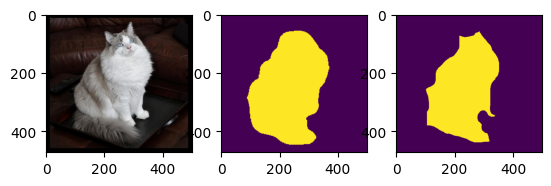

In [81]:
import matplotlib.pyplot as plt

NUM_VIS_IMG = 10
f, axes = plt.subplots(1,3)

# original images
axes[0].imshow(np.array(
        Image.open(os.path.join(val_imgs_path, val_img_names[NUM_VIS_IMG]))
    )
)

# predicted
axes[1].imshow(val_seg_masks[NUM_VIS_IMG])

# ground truth
axes[2].imshow(np.array(
        Image.open(os.path.join(val_masks_path, val_img_names[NUM_VIS_IMG].replace('jpg', 'png')))
    )
)